In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tcn import TCN
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Concatenate, Attention, Dropout
from tensorflow.keras.callbacks import EarlyStopping            
from tensorflow.keras.optimizers import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

warnings.filterwarnings('ignore')


In [13]:
file_path = "myData2.parquet"
df = pd.read_parquet(file_path)


In [14]:
selected_features = ['timestamp_seconds', 
                     'node_memory_Percpu_bytes', 
                     'node_context_switches_total', 
                     'surfsara_power_usage', 
                     'node_netstat_Tcp_InSegs', 
                     'node_netstat_Tcp_OutSegs', 
                     'node_network_transmit_packets_total-sum', 
                     'node_filesystem_size_bytes-sum', 
                     'node_filesystem_files-sum', 
                     'node_memory_MemFree_bytes', 
                     'node_netstat_Tcp_InErrs']
# FixMe

In [15]:
# Define time intervals
time_intervals = {'minute': '1T', 'hour': '1H', 'day': '1D'}

# Set sequence length
sequence_length = 30

# Number of time steps to predict into the future
prediction_steps = 7

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [16]:
# Function to prepare data
def prepare_data(data, time_interval):
    data.set_index('timestamp', inplace=True)
    data_resampled = data.resample(time_interval).sum()
    
    target_mean = data_resampled['target'].mean()
    target_std = data_resampled['target'].std()
    data_resampled['target'] = (data_resampled['target'] - target_mean) / target_std
    
    target_min = data_resampled['target'].min()
    target_max = data_resampled['target'].max()
    print("Minimum value of target variable:", target_min)
    print("Maximum value of target variable:", target_max)
    
    return data_resampled

# Function to create sequences
def create_sequences(data, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length].values
        target = data.iloc[i+sequence_length]['target']
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)


In [17]:
# Function to create a hybrid model with attention mechanism
def create_attention_hybrid_model(lstm_model, tcn_model):
    lstm_input = lstm_model.input
    tcn_input = tcn_model.input

    # Get the output layers of both models
    lstm_output = lstm_model.layers[-1].output
    tcn_output = tcn_model.layers[-1].output

    # Use Attention mechanism to combine outputs
    attention = Attention()([lstm_output, tcn_output])
    merged = Concatenate()([lstm_output, tcn_output, attention])

    # Add a dense layer for the final prediction
    merged = Dense(1, activation='sigmoid')(merged)

    # Create the ensemble model
    ensemble_model = Model(inputs=[lstm_input, tcn_input], outputs=merged)

    # Compile the model
    ensemble_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

    return ensemble_model


In [18]:
# Function to make predictions on new data for the hybrid model
def predict_future_failures_hybrid(model, input_data_lstm, input_data_tcn, sequence_length, prediction_steps):
    predictions = []

    for _ in range(prediction_steps):
        # Make predictions for the next time step using both LSTM and TCN models
        prediction = model.predict([input_data_lstm.reshape(1, sequence_length, input_data_lstm.shape[1]),
                                    input_data_tcn.reshape(1, sequence_length, input_data_tcn.shape[1])])
        predictions.append(prediction[0, 0])

        # Shift the input data by one time step and append the new prediction
        input_data_lstm = np.roll(input_data_lstm, shift=-1, axis=0)
        input_data_lstm[-1, -1] = prediction[0, 0]

        input_data_tcn = np.roll(input_data_tcn, shift=-1, axis=0)
        input_data_tcn[-1, -1] = prediction[0, 0]

    return predictions


# 30 days -> 7 days

In [19]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])


In [20]:
# Prepare data with daily intervals
data_day = prepare_data(df_selected, time_intervals['day'])

# Create sequences and targets
sequences_day, targets_day = create_sequences(data_day, sequence_length)

# Define the index to split the data
split_index_day = int(len(sequences_day) * 0.7)  # Use 70% of the data for training

# Split the data into training and testing sets
X_train_day, X_test_day = sequences_day[:split_index_day], sequences_day[split_index_day:]
y_train_day, y_test_hour = targets_day[:split_index_day], targets_day[split_index_day:]

# Build the LSTM model
lstm_model_day = Sequential()
lstm_model_day.add(LSTM(8, input_shape=(X_train_day.shape[1], X_train_day.shape[2])))
lstm_model_day.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.0005)
lstm_model_day.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])

# Train the model
lstm_model_day.fit(X_train_day, y_train_day, epochs=10, batch_size=16, validation_split=0.15)

# Build the TCN model
tcn_model_day = Sequential([
    TCN(input_shape=(sequence_length, X_train_day.shape[2])),
    Dense(1, activation='sigmoid')
])
tcn_model_day.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
tcn_model_day.fit(X_train_day, y_train_day, epochs=20, batch_size=32, validation_split=0.1)

# Create the hybrid model
hybrid_model_attention_day = create_attention_hybrid_model(lstm_model_day, tcn_model_day)

# Train the hybrid model with both LSTM and TCN data
history_day = hybrid_model_attention_day.fit([X_train_day, X_train_day], y_train_day, epochs=20, batch_size=32, validation_split=0.1)


Minimum value of target variable: -0.7362924419461765
Maximum value of target variable: 5.322951443655186
Epoch 1/10


4/4 [==============================] - 2s 184ms/step - loss: 1.1691 - mean_squared_error: 1.1691 - val_loss: 1.8359 - val_mean_squared_error: 1.8359
Epoch 2/10
4/4 [==============================] - 0s 32ms/step - loss: 1.1598 - mean_squared_error: 1.1598 - val_loss: 1.8339 - val_mean_squared_error: 1.8339
Epoch 3/10
4/4 [==============================] - 0s 35ms/step - loss: 1.1626 - mean_squared_error: 1.1626 - val_loss: 1.8315 - val_mean_squared_error: 1.8315
Epoch 4/10
4/4 [==============================] - 0s 33ms/step - loss: 1.1588 - mean_squared_error: 1.1588 - val_loss: 1.8288 - val_mean_squared_error: 1.8288
Epoch 5/10
4/4 [==============================] - 0s 33ms/step - loss: 1.1444 - mean_squared_error: 1.1444 - val_loss: 1.8065 - val_mean_squared_error: 1.8065
Epoch 6/10
4/4 [==============================] - 0s 33ms/step - loss: 1.0916 - mean_squared_error: 1.0916 - val_loss: 1.7200 - val_mean_squared_error: 1.7200
Epoch 7/10
4/4 [==============================] - 0s 33m

## Performance_Day

In [21]:
# Evaluate the model using Mean Squared Error
mse_day = hybrid_model_attention_day.evaluate([X_test_day, X_test_day], y_test_hour, verbose=0)[1]
print(f'Mean Squared Error: {mse_day:.4f}\n')


Mean Squared Error: 2.2673



In [25]:
# Evaluate model on test data
y_pred_day = hybrid_model_attention_day.predict([X_test_day, X_test_day])

# Calculate Root Mean Squared Error
rmse_day = mean_squared_error(y_test_hour, y_pred_day, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse_day:.4f}\n')

# Calculate Mean Absolute Error
mae_day = mean_absolute_error(y_test_hour, y_pred_day)
print(f'Mean Abosolute Error: {mae_day:.4f}\n')

# Calculate R-squared
r2_day = r2_score(y_test_hour, y_pred_day)
print(f'R-squared (R2): {r2_day:.4f}\n')


1/1 [==============================] - 0s 34ms/step
Root Mean Squared Error (RMSE): 1.5057

Mean Abosolute Error: 1.0906

R-squared (R2): -0.0943



### Training and Validation Loss Plot

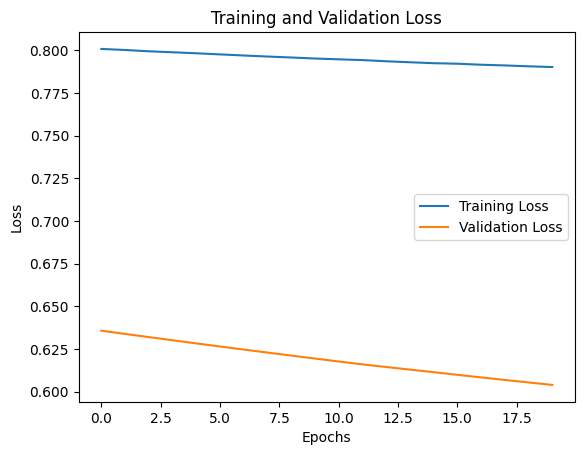

In [26]:
# Plot training and validation loss
plt.plot(history_day.history['loss'], label='Training Loss')
plt.plot(history_day.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Predicted Failures vs. True Failures Plot

In [27]:
target_min_day = -0.7362924419461765
target_max_day = 5.322951443655186

1/1 [==============================] - 0s 24ms/step
Predicted failures for the next 7 days:
[0.17678411, 0.1565178, 0.15581913, 0.15651815, 0.15651815, 0.15651815, 0.15651815]

Mean Squared Error for Predictions: 0.3593

Mean Absolute Error for Predictions: 0.5994


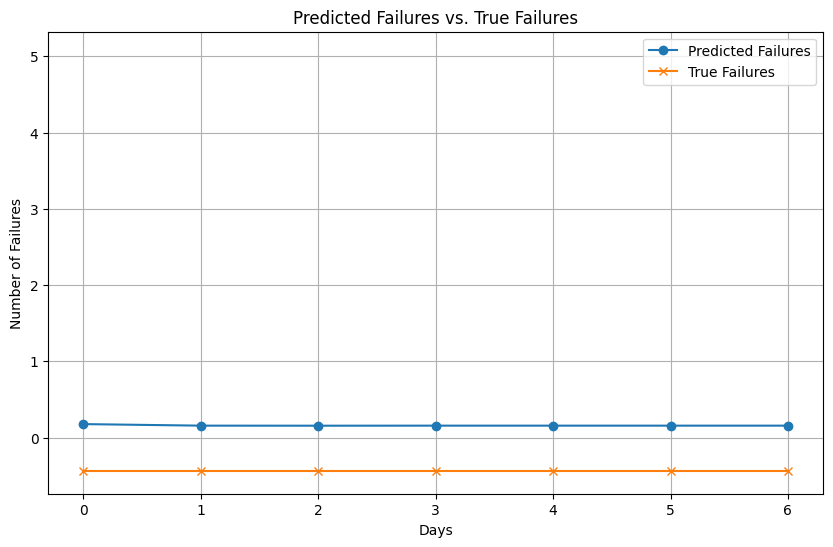

In [53]:
index_day = 8  # Can be any valid starting point

input_data_day = X_test_day[index_day]

# Make predictions
predicted_failures_hour = predict_future_failures_hybrid(hybrid_model_attention_day, input_data_day, input_data_day, sequence_length, prediction_steps)

# # Denormalize the predicted failures 
# predicted_failures_denormalized_day = np.array(predicted_failures_day) * (target_max_day - target_min_day) + target_min_day

# Get the true failures for the specified number of days
true_failures_hour = y_test_hour[index_day:index_day + prediction_steps]

# Print the predicted failures
print("Predicted failures for the next 7 days:")
print(predicted_failures_hour)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures_hour - true_failures_hour)**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures_hour - true_failures_hour))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_hour, label='Predicted Failures', marker='o')
plt.plot(true_failures_hour, label='True Failures', marker='x')
plt.xlabel('Days')
plt.ylabel('Number of Failures')
plt.title('Predicted Failures vs. True Failures')
plt.legend()
plt.ylim(target_min_day, target_max_day)
plt.grid(True)
plt.show()


# 30 hours -> 7 hours

In [34]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])


In [35]:
# Prepare data with hourly intervals
data_hour = prepare_data(df_selected, time_intervals['hour'])

# Create sequences and targets
sequences_hour, targets_hour = create_sequences(data_hour, sequence_length)

# Define the index to split the data
split_index_hour = int(len(sequences_hour) * 0.7)  # Use 70% of the data for training

# Split the data into training and testing sets
X_train_hour, X_test_hour = sequences_hour[:split_index_hour], sequences_hour[split_index_hour:]
y_train_hour, y_test_hour = targets_hour[:split_index_hour], targets_hour[split_index_hour:]

# Build the LSTM model
lstm_model_hour = Sequential()
lstm_model_hour.add(LSTM(20, input_shape=(X_train_hour.shape[1], X_train_hour.shape[2])))
lstm_model_hour.add(Dense(1, activation='sigmoid'))
lstm_model_hour.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
lstm_model_hour.fit(X_train_hour, y_train_hour, epochs=10, batch_size=16, validation_split=0.15)

# Build the TCN model
tcn_model_hour = Sequential([
    TCN(input_shape=(sequence_length, X_train_hour.shape[2])),
    Dense(1, activation='sigmoid')
])
tcn_model_hour.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
tcn_model_hour.fit(X_train_hour, y_train_hour, epochs=20, batch_size=32, validation_split=0.1)

# Create the hybrid model
hybrid_model_attention_hour = create_attention_hybrid_model(lstm_model_hour, tcn_model_hour)

# Train the hybrid model with both LSTM and TCN data
history_hour = hybrid_model_attention_hour.fit([X_train_hour, X_train_hour], y_train_hour, epochs=20, batch_size=32, validation_split=0.1)


Minimum value of target variable: -0.44004356707964004
Maximum value of target variable: 22.33986610637043
Epoch 1/10
102/102 [==============================] - 4s 25ms/step - loss: 0.3490 - mean_squared_error: 0.3490 - val_loss: 0.4180 - val_mean_squared_error: 0.4180
Epoch 2/10
102/102 [==============================] - 2s 20ms/step - loss: 0.2210 - mean_squared_error: 0.2210 - val_loss: 0.4205 - val_mean_squared_error: 0.4205
Epoch 3/10
102/102 [==============================] - 2s 20ms/step - loss: 0.2045 - mean_squared_error: 0.2045 - val_loss: 0.4158 - val_mean_squared_error: 0.4158
Epoch 4/10
102/102 [==============================] - 2s 20ms/step - loss: 0.1991 - mean_squared_error: 0.1991 - val_loss: 0.4225 - val_mean_squared_error: 0.4225
Epoch 5/10
102/102 [==============================] - 2s 19ms/step - loss: 0.1927 - mean_squared_error: 0.1927 - val_loss: 0.3972 - val_mean_squared_error: 0.3972
Epoch 6/10
102/102 [==============================] - 2s 19ms/step - loss: 0.1

## Performance_Hour

In [38]:
# Evaluate the model using Mean Squared Error
mse_hour = hybrid_model_attention_hour.evaluate([X_test_hour, X_test_hour], y_test_hour, verbose=0)[1]
print(f'Mean Squared Error: {mse_hour:.4f}\n')


Mean Squared Error: 2.7305



In [39]:
# Evaluate model on test data
y_pred_hour = hybrid_model_attention_hour.predict([X_test_hour, X_test_hour])

# Calculate Root Mean Squared Error
rmse_hour = mean_squared_error(y_test_hour, y_pred_hour, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse_hour:.4f}\n')

# Calculate Mean Absolute Error
mae_hour = mean_absolute_error(y_test_hour, y_pred_hour)
print(f'Mean Abosolute Error: {mae_hour:.4f}\n')

# Calculate R-squared
r2_hour = r2_score(y_test_hour, y_pred_hour)
print(f'R-squared (R2): {r2_hour:.4f}\n')


26/26 [==============================] - 1s 18ms/step
Root Mean Squared Error (RMSE): 1.6524

Mean Abosolute Error: 0.7148

R-squared (R2): 0.0011



### Training and Validation Loss Plot

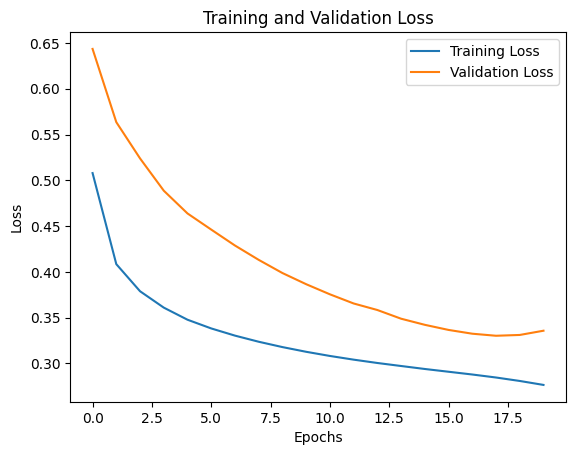

In [40]:
# Plot training and validation loss
plt.plot(history_hour.history['loss'], label='Training Loss')
plt.plot(history_hour.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Predicted Failures vs. True Failures Plot

In [41]:
target_min_hour =  0.44004356707964004
target_max_hour = 22.33986610637043


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step
Predicted failures for the next 7 hours:
[0.17860168, 0.17215413, 0.17215703, 0.17216705, 0.17224291, 0.17280442, 0.17657925]

Mean Squared Error for Predictions: 0.3768

Mean Absolute Error for Predictions: 0.6139


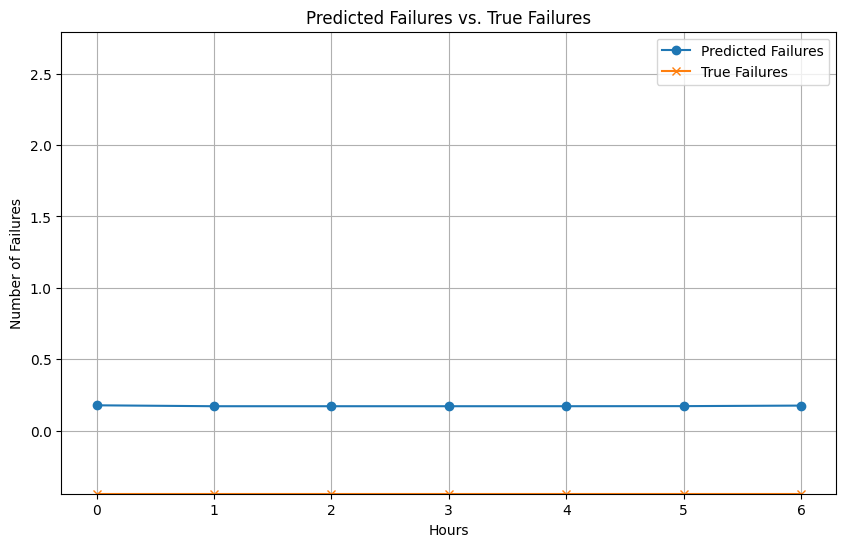

In [71]:
index_hour = 8  # Can be any valid starting point

input_data_hour = X_test_hour[index_hour]

# Make predictions
predicted_failures_hour = predict_future_failures_hybrid(hybrid_model_attention_day, input_data_hour, input_data_hour, sequence_length, prediction_steps)

# # Denormalize the predicted failures 
# predicted_failures_denormalized_hour = np.array(predicted_failures_hour) * (target_max_hour - target_min_hour) + target_min_hour

# Get the true failures for the specified number of hours
true_failures_hour = y_test_hour[index_hour:index_hour + prediction_steps]

# Print the predicted failures
print("Predicted failures for the next 7 hours:")
print(predicted_failures_hour)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures_hour - true_failures_hour)**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures_hour - true_failures_hour))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_hour, label='Predicted Failures', marker='o')
plt.plot(true_failures_hour, label='True Failures', marker='x')
plt.xlabel('Hours')
plt.ylabel('Number of Failures')
plt.title('Predicted Failures vs. True Failures')
plt.legend()
plt.ylim(-target_min_hour, target_max_hour/8)
plt.grid(True)
plt.show()


# 30 minutes -> 7 minutes

In [45]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])


In [46]:
# Prepare data
data_minute = prepare_data(df_selected, time_intervals['minute'])

# Create sequences and targets
sequences_minute, targets_minute = create_sequences(data_minute, sequence_length)

# Split the data into training and testing sets
X_train_minute, X_test_minute, y_train_minute, y_test_minute = train_test_split(sequences_minute, targets_minute, test_size=0.2, random_state=1)

# Build the LSTM model
lstm_model_minute = Sequential()
lstm_model_minute.add(LSTM(50, input_shape=(X_train_minute.shape[1], X_train_minute.shape[2])))
lstm_model_minute.add(Dense(1, activation='sigmoid'))
lstm_model_minute.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
lstm_model_minute.fit(X_train_minute, y_train_minute, epochs=10, batch_size=16, validation_split=0.15)

# Build the TCN model
tcn_model_minute = Sequential([
    TCN(input_shape=(sequence_length, X_train_minute.shape[2])),
    Dense(1, activation='sigmoid')
])

tcn_model_minute.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
tcn_model_minute.fit(X_train_minute, y_train_minute, epochs=5, batch_size=32, validation_split=0.1)

# Create the hybrid model
hybrid_model_attention_min = create_attention_hybrid_model(lstm_model_minute, tcn_model_minute)

# Train the hybrid model with both LSTM and TCN data
history_min = hybrid_model_attention_min.fit([X_train_minute, X_train_minute], y_train_minute, epochs=10, batch_size=32, validation_split=0.1)


Minimum value of target variable: -0.43499466427008204
Maximum value of target variable: 22.077561101301857
Epoch 1/10
7033/7033 [==============================] - 150s 21ms/step - loss: 0.7282 - mean_squared_error: 0.7282 - val_loss: 0.7695 - val_mean_squared_error: 0.7695
Epoch 2/10
7033/7033 [==============================] - 148s 21ms/step - loss: 0.7245 - mean_squared_error: 0.7245 - val_loss: 0.7693 - val_mean_squared_error: 0.7693
Epoch 3/10
7033/7033 [==============================] - 150s 21ms/step - loss: 0.7244 - mean_squared_error: 0.7244 - val_loss: 0.7693 - val_mean_squared_error: 0.7693
Epoch 4/10
7033/7033 [==============================] - 151s 21ms/step - loss: 0.7244 - mean_squared_error: 0.7244 - val_loss: 0.7697 - val_mean_squared_error: 0.7697
Epoch 5/10
7033/7033 [==============================] - 150s 21ms/step - loss: 0.7244 - mean_squared_error: 0.7244 - val_loss: 0.7693 - val_mean_squared_error: 0.7693
Epoch 6/10
7033/7033 [==============================] - 1

## Performance_Minute

In [47]:
# Evaluate the model using Mean Squared Error
mse_min = hybrid_model_attention_min.evaluate([X_test_minute, X_test_minute], y_test_minute, verbose=0)[1]
print(f'Mean Squared Error: {mse_min:.4f}\n')


Mean Squared Error: 0.7913



In [48]:
# Evaluate model on test data
y_pred_minute = hybrid_model_attention_min.predict([X_test_minute, X_test_minute])

# Calculate Root Mean Squared Error
rmse_minute = mean_squared_error(y_test_minute, y_pred_minute, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse_day:.4f}\n')

# Calculate Mean Absolute Error
mae_min = mean_absolute_error(y_test_minute, y_pred_minute)
print(f'Mean Abosolute Error: {mae_min:.4f}\n')

# Calculate R-squared
r2_min = r2_score(y_test_minute, y_pred_minute)
print(f'R-squared (R2): {r2_min:.4f}\n')


1035/1035 [==============================] - 20s 18ms/step
Root Mean Squared Error (RMSE): 1.5057

Mean Abosolute Error: 0.3302

R-squared (R2): 0.2507



### Training and Validation Loss Plot

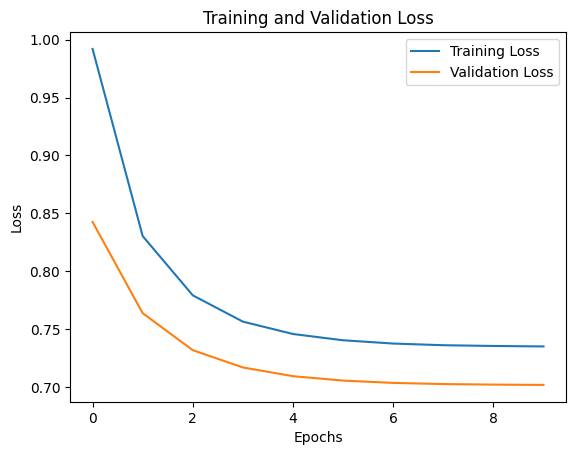

In [49]:
# Plot training and validation loss
plt.plot(history_min.history['loss'], label='Training Loss')
plt.plot(history_min.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Predicted Failures vs. True Failures Plot

In [51]:
target_min_minute =  -0.43499466427008204
target_max_minute = 22.077561101301857


1/1 [==============================] - 0s 24ms/step
Predicted failures for the next 7 minutes
[0.27382132, 0.28676984, 0.3166903, 0.38478404, 0.5386371, 0.77862316, 0.88887227]

Mean Squared Error for Predictions: 0.1835

Mean Absolute Error for Predictions: 0.3055


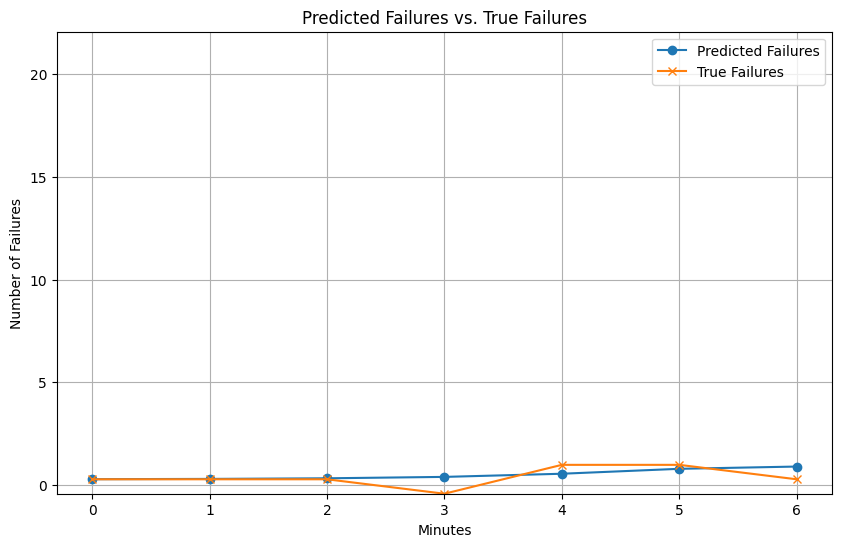

In [52]:
index_minute = 0  # Can be any valid starting point

input_data_minute = X_test_minute[index_minute]

# Make predictions
predicted_failures_minute = predict_future_failures_hybrid(hybrid_model_attention_min, input_data_minute, input_data_minute, sequence_length, prediction_steps)

# # Denormalize the predicted failures 
# predicted_failures_denormalized_minute = np.array(predicted_failures_minute) * (target_max_minute - target_min_minute) + target_min_minute

# Get the true failures for the specified number of minutes
true_failures_minute = y_test_minute[index_minute:index_minute + prediction_steps]

# Print the predicted failures
print("Predicted failures for the next 7 minutes")
print(predicted_failures_minute)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures_minute - true_failures_minute)**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures_minute - true_failures_minute))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_minute, label='Predicted Failures', marker='o')
plt.plot(true_failures_minute, label='True Failures', marker='x')
plt.xlabel('Minutes')
plt.ylabel('Number of Failures')
plt.title('Predicted Failures vs. True Failures')
plt.legend()
plt.ylim(target_min_minute, target_max_minute)
plt.grid(True)
plt.show()


# Comparison between Diff. Time Granularity

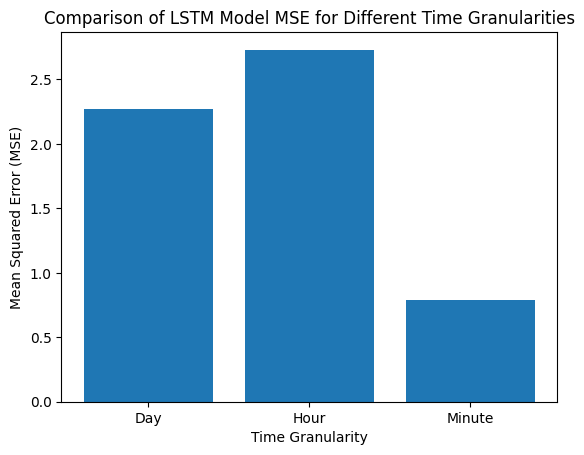

In [72]:
# Plot MSE for different time granularities
time_granularities = ['Day', 'Hour', 'Minute']
mse_values = [mse_day, mse_hour, mse_min]

plt.bar(time_granularities, mse_values)
plt.title('Comparison of LSTM Model MSE for Different Time Granularities')
plt.xlabel('Time Granularity')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()